<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/correlation/folder/Nifty_Crude_corr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykalman

     |████████████████████████████████| 228 kB 13.7 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48462 sha256=dbd6f95377a0739515f308af274e30f28cd7f479fa93ff9a00510435a7cd4de8
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import datetime
from pykalman import  KalmanFilter

In [3]:
data = pd.read_csv('/content/crude.csv')

In [4]:
data['date']=data.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))

In [5]:
del data['time']

In [6]:
data= data.set_index('date')



In [7]:
data.head(2)

,open,high,low,close,"CRUDEOIL1!, MCX: Open","CRUDEOIL1!, MCX: High","CRUDEOIL1!, MCX: Low","CRUDEOIL1!, MCX: Close",Volume,Volume MA
date,,,,,,,,,,
25-06-2014,7588.5498,7589.2500,7557.0498,7569.2500,NaN,NaN,NaN,NaN,NaN,NaN
26-06-2014,7554.1001,7570.2002,7481.2998,7493.2002,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data=data['29-05-2018':]

In [9]:
data.tail(2)

,open,high,low,close,"CRUDEOIL1!, MCX: Open","CRUDEOIL1!, MCX: High","CRUDEOIL1!, MCX: Low","CRUDEOIL1!, MCX: Close",Volume,Volume MA
date,,,,,,,,,,
08-02-2022,17279.85,17306.449,17043.65,17266.750,6809.0,6837.0,6616.0,6700.0,NaN,NaN
09-02-2022,17370.10,17477.150,17339.00,17463.801,6692.0,6777.0,6618.0,6675.0,NaN,NaN


In [10]:
data_subset = data[['close','CRUDEOIL1!, MCX: Close']]

In [11]:
data_subset.columns=['close','close1']


In [12]:
data_subset.head(2)

,close,close1
date,,
29-05-2018,10633.30,4527.0
30-05-2018,10614.35,4614.0


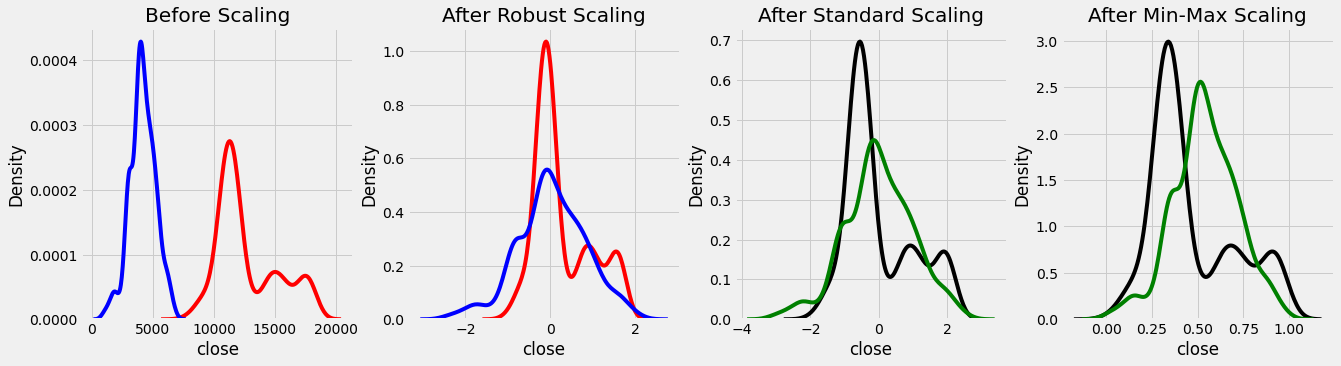

In [13]:
# Importing libraries
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
% matplotlib inline
matplotlib.style.use('fivethirtyeight')

# data
x = data_subset
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['close','close1'])

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['close','close1'])

scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =['close','close1'])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')

sns.kdeplot(x['close'], ax = ax1, color ='r')
sns.kdeplot(x['close1'], ax = ax1, color ='b')
ax2.set_title('After Robust Scaling')

sns.kdeplot(robust_df['close'], ax = ax2, color ='red')
sns.kdeplot(robust_df['close1'], ax = ax2, color ='blue')
ax3.set_title('After Standard Scaling')

sns.kdeplot(standard_df['close'], ax = ax3, color ='black')
sns.kdeplot(standard_df['close1'], ax = ax3, color ='g')
ax4.set_title('After Min-Max Scaling')

sns.kdeplot(minmax_df['close'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['close1'], ax = ax4, color ='g')
plt.show()


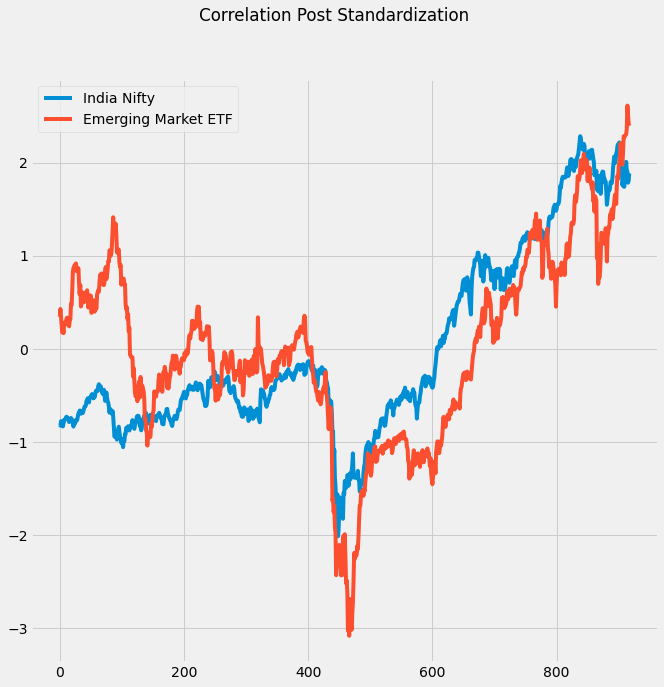

In [14]:
columns=['India Nifty','Emerging Market ETF']
standard_df=standard_df.fillna(method='ffill')
standard_df.columns=columns
standard_df[-1200:].plot(figsize=(10,10))
plt.suptitle('Correlation Post Standardization')
plt.show()

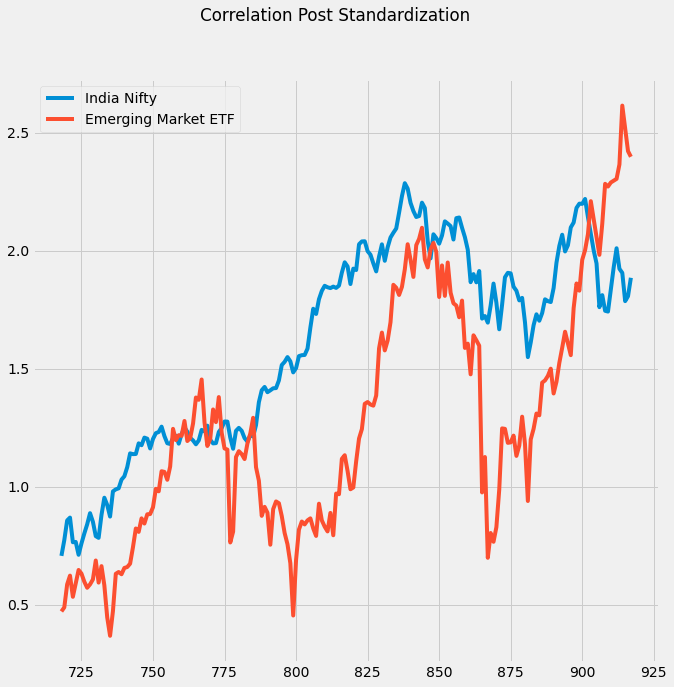

In [15]:
standard_df.columns=columns
standard_df[-200:].plot(figsize=(10,10))
plt.suptitle('Correlation Post Standardization')
plt.show()

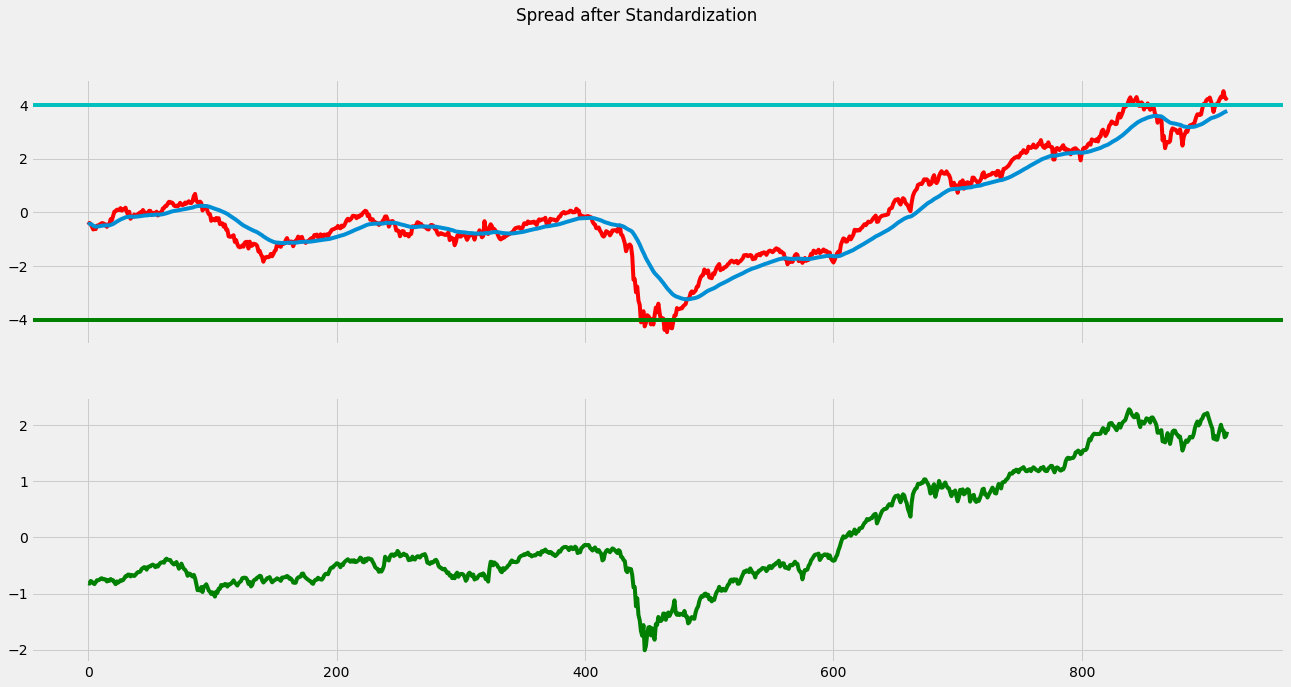

In [16]:
standard_df['diff']=standard_df['India Nifty']+standard_df['Emerging Market ETF']
standard_df['mov_avg']=standard_df['diff'].ewm(span=50).mean()
plt.rcParams["figure.figsize"] = (20,10)
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].plot(standard_df['diff'],color='r')
ax[1].plot(standard_df['India Nifty'],color='g')
ax[0].axhline(y=4,color='c')
ax[0].axhline(y=-4,color='g')
plt.suptitle('Spread after Standardization')

ax[0].plot(standard_df['mov_avg'])
plt.show()


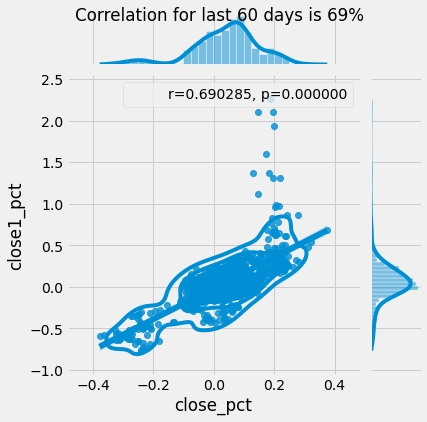

In [17]:
data_subset['close_pct']=data_subset['close'].pct_change(60)
data_subset['close1_pct']=data_subset['close1'].pct_change(60)

data_subset.dropna(inplace=True)
g=sns.jointplot(x='close_pct',y='close1_pct',data=data_subset,kind='reg').plot_joint(sns.kdeplot,n_levels=6)
r, p = pearsonr(data_subset['close_pct'], data_subset['close1_pct'])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
plt.suptitle(f'Correlation for last 60 days is {round(r*100)}%')
plt.show()

In [18]:
df = standard_df[['diff']]


mean 2.804013956067992


Text(0.5, 0, 'Days')

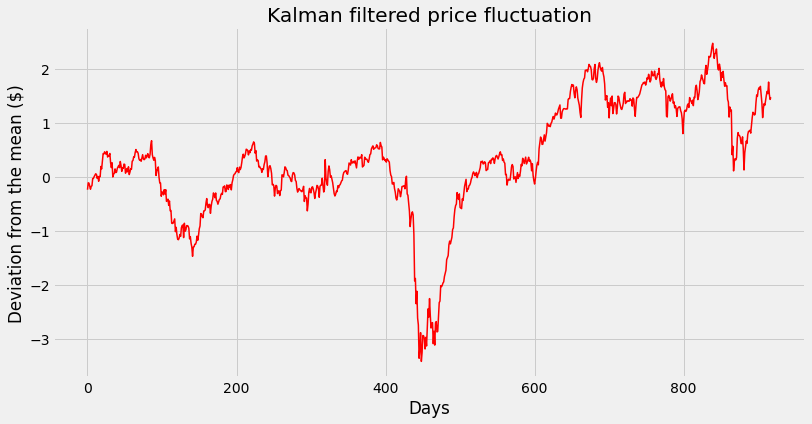

In [19]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)
mean, cov = f.filter(df['diff'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')

plt.figure(figsize=(12,6))
plt.plot(df['diff'].values - mean, 'red', lw=1.5)


plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [20]:
spread= pd.DataFrame({'Date':df.index,'spread':(df['diff'].values - mean)})

In [21]:
spread=spread.set_index('Date')

In [22]:
df_new=pd.concat([df,spread['spread']],axis=1)

In [23]:
df_new['30 Day MA'] = df_new['spread'].rolling(window=50).mean()
# set .std(ddof=0) for population std instead of sample
df_new['30 Day STD'] = df_new['spread'].rolling(window=50).std() 
df_new['Upper Band'] = df_new['30 Day MA'] + (df_new['30 Day STD'] *2)
df_new['Lower Band'] = df_new['30 Day MA'] - (df_new['30 Day STD'] *2)
df_new['boll_percent'] = (df_new['spread']-df_new['Lower Band'])/(df_new['Upper Band']-df_new['Lower Band'])

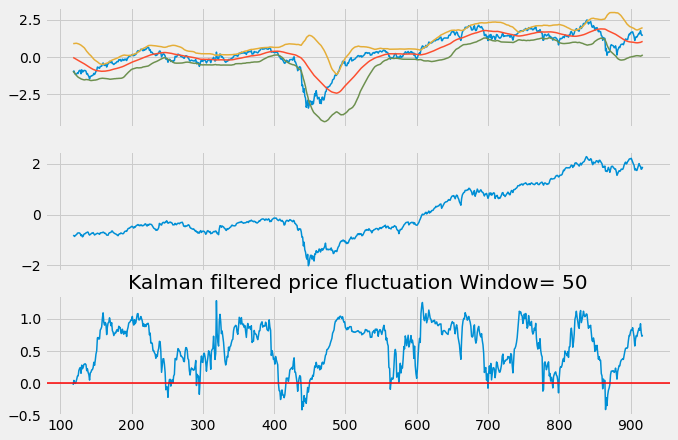

In [24]:
fig, ax = plt.subplots(3,1,figsize=(10,7),sharex=True)
#plt.plot(df_new['Adj Close'].values - mean, 'red', lw=1.5)
ax[0].plot(df_new[['spread','30 Day MA','Upper Band','Lower Band']][-800:],lw=1.5)

#plt.axhline(y=1000)
#plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation Window= 50")
#ax[0].ylabel("Deviation from the mean ($)")
#ax[0].xlabel("Days")
ax[2].plot(df_new[['boll_percent']][-800:],lw=1.5)
ax[2].axhline(y=0,color='r',lw=1.5)
ax[1].plot(standard_df[['India Nifty']][-800:],lw=1.5)
plt.show()